In [1]:
import pandas as pd
import numpy as np
import json
import pickle
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import seaborn as sns
from datetime import datetime
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, cv, plot_importance
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [2]:
logins = pd.read_json('logins.json')
logins['login_count'] = 1
# convert the date to a datetime object
logins = logins.set_index(pd.to_datetime(logins['login_time'], unit='s'))[['login_count']]

In [3]:
# resample the index, so that time is represented in 15min chunks
logins_delta15 = logins.resample('15Min').sum()

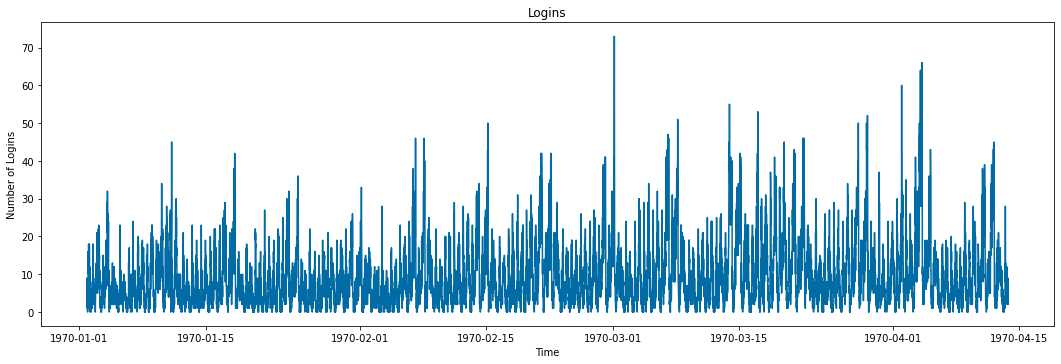

In [4]:
# scatterplot of the binned data
fig, ax = plt.subplots(figsize = (15,5))
plt.xlabel('Time')
plt.ylabel('Number of Logins')
plt.tight_layout()
plt.title('Logins')
# puts the data in the figure
plt.plot(logins_delta15.index, logins_delta15.login_count)

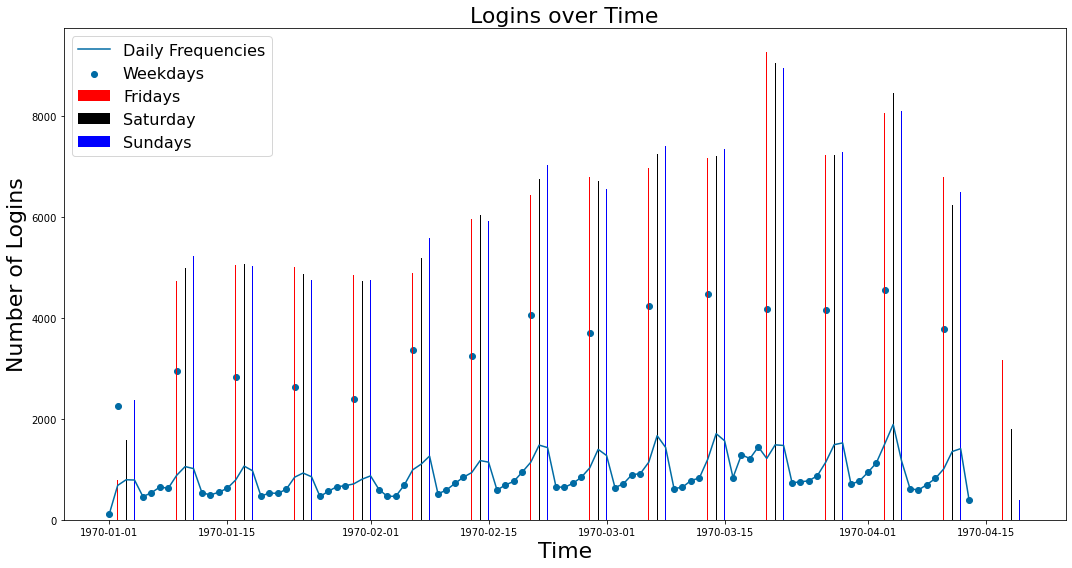

In [5]:
# bin data by the day
logins_daily = logins.resample('D').sum()
logins_biz_day = logins.resample('B').sum()
fridays = logins.resample('W-FRI').sum()
saturdays = logins.resample('W-SAT').sum()
sundays = logins.resample('W-SUN').sum()


# line, scatterplot, and histograms of the binned data
fig, ax = plt.subplots(figsize = (15,8))
plt.xlabel('Time', fontsize = 22)
plt.ylabel('Number of Logins', fontsize = 22)
plt.title('Logins over Time', fontsize = 22)
plt.bar(fridays.index, fridays.login_count, align= 'center', width = 0.1, label = "Fridays", color = 'Red')
plt.bar(saturdays.index, saturdays.login_count, label = 'Saturday', align = 'center', width = 0.1, color = 'Black')
plt.bar(sundays.index, sundays.login_count, label = "Sundays", align= 'center', width = 0.1, color = 'Blue')
plt.plot(logins_daily.index, logins_daily.login_count, label = 'Daily Frequencies')
plt.scatter(logins_biz_day.index, logins_biz_day.login_count, label='Weekdays')

plt.legend(loc='upper left', fontsize = 16)
plt.tight_layout()

In [6]:
# resample index hourly
daily_logins = logins.resample('H').sum()
day_of_week = list(daily_logins.index.dayofweek)
daily_logins['day_of_week'] = day_of_week
# add column for day and hour
daily_logins['hour'] = [time.hour for time in daily_logins.index]

In [7]:
# create dataframe of the average number of logins for each hour of each day
avg_hourly_logins = pd.pivot_table(daily_logins, values = 'login_count', index = 'hour', columns = 'day_of_week', aggfunc=np.mean).rename(columns= {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})
avg_hourly_logins = avg_hourly_logins.stack(level=['day_of_week'])
avg_hourly_logins.name = 'avg_num_logins'
avg_hourly_logins_df = avg_hourly_logins.reset_index()

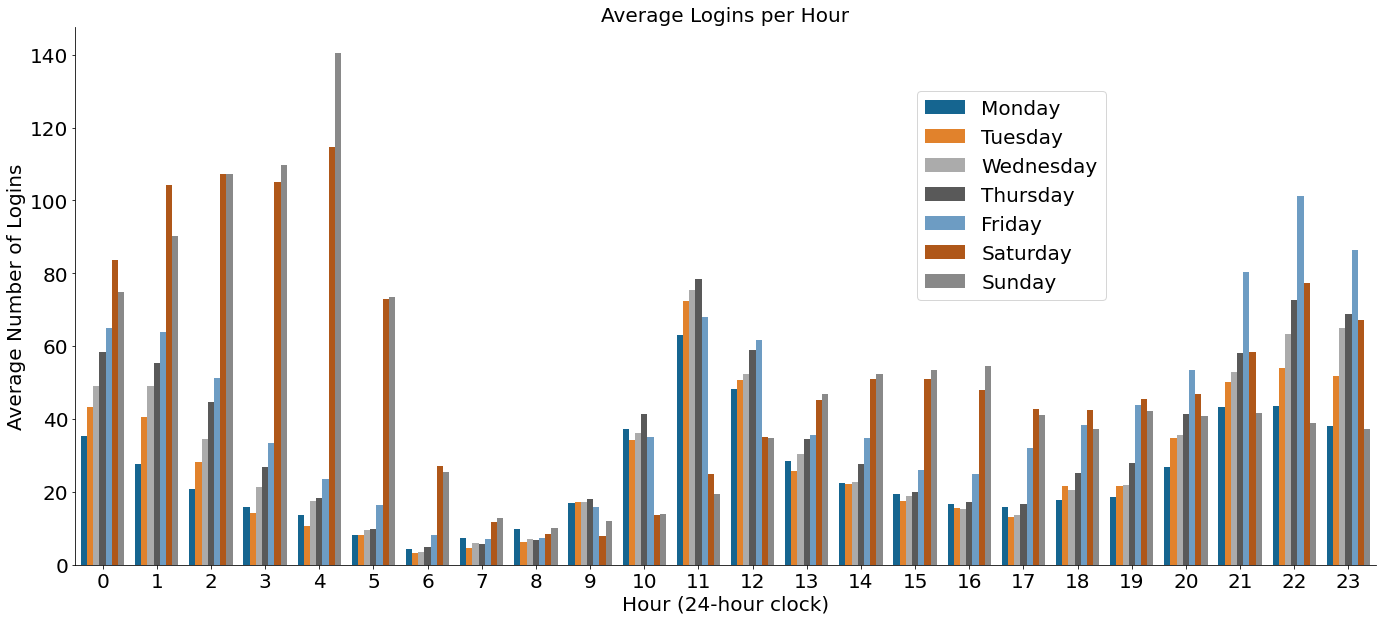

In [8]:
# plot average hourly use
sns.catplot(x='hour', y='avg_num_logins', data=avg_hourly_logins_df, kind = 'bar', 
            hue='day_of_week',height=8, aspect=11.7/5, legend=False)
ax = plt.gca()
ax.set_title('Average Logins per Hour', fontsize = 20)
ax.set_xlabel('Hour (24-hour clock)', fontsize = 20)
ax.set_ylabel('Average Number of Logins', fontsize = 20)
ax.tick_params(labelsize=20,labelcolor="black")
ax.legend(bbox_to_anchor=(0.7,0.7,0.1, 0.2),fontsize=20)

In [9]:

#What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
    #- weekday activity. Easy to measure
#Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
#how you will implement the experiment
    #hypothesis testing, predicting there was a difference between mean number of cars before or after reimbursement
#what statistical test(s) you will conduct to verify the significance of the observation
#one tailed z test to determine p value
#how you would interpret the results and provide recommendations to the city operations team along with any caveats.
# The p value in relation to 0.05 would determine if I can reject the null hypothesis or not

In [10]:
# load data
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)

user_data = pd.DataFrame(data)

# convert to datatime
user_data['signup_date'] = pd.to_datetime(user_data['signup_date'])
user_data['last_trip_date'] = pd.to_datetime(user_data['last_trip_date'])

# find pull date
pull_date = user_data.last_trip_date.max()

# get cut off day
cut_off_day = pull_date - pd.Timedelta('30 days')

# add active status to dataframe
user_data['active_status'] = (user_data.last_trip_date > cut_off_day).astype('int')

# add dummies to categorical data
user_data = pd.get_dummies(user_data, columns = ['city', 'phone'])

In [11]:
# separate active and inactive users
active_user = user_data[user_data.active_status == 1]
inactive_user = user_data[user_data.active_status == 0]

In [12]:
# pct of the observed users that were retained
perc = round((len(active_user.active_status)/len(user_data.active_status)) * 100, 2)
print('{} percent of users were retained.'.format(perc))

36.62 percent of users were retained.


In [13]:
# calculate the mean and std dev
feature_columns = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'city_Astapor',
 "city_King's Landing", 'city_Winterfell', 'phone_Android','phone_iPhone']
stats_dict = {}
for i in feature_columns:
    stats_dict[i] = [active_user[i].mean(), active_user[i].std(),
                       inactive_user[i].mean(),inactive_user[i].std()]

In [14]:
# create a dataframe of stats
stats_df = pd.DataFrame.from_dict(stats_dict, orient='index').rename(columns = {0:'active_mean', 1:'active_std', 2:'inactive_mean', 3:'inactive_std'})

Text(0.5, 1.0, 'Average of Features for Active and Inactive Users')

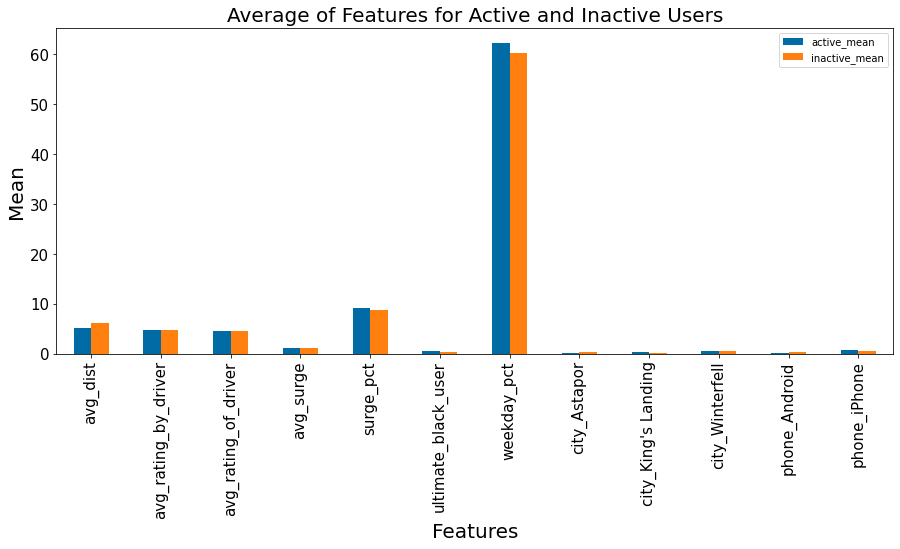

In [15]:
# visualize the statistics
stats_df[['active_mean', 'inactive_mean']].plot(kind = 'bar', yerr=stats_df[['active_std','inactive_std']], figsize = (15,6), fontsize = 15)
plt.xlabel('Features',fontsize = 20)
plt.ylabel('Mean', fontsize = 20)
plt.title('Average of Features for Active and Inactive Users', fontsize = 20)

In [16]:
X = user_data[feature_columns]
y = user_data.active_status
# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=123)

In [17]:
# dictionary of parameters to optimize, and the range of optimization values
parameters = {
    'max_delta_step':[0,0.05],
    'scale_pos_weight':[0.95, 0.9],
    'subsample':[1,0.8],
    'learning_rate': [0.25, 0.2, 0.1],
    'min_child_weight':[0,1,2],
    'gamma':[1, 2, 3]
    }

In [18]:
# instantiate classifier
xg_clf = XGBClassifier(objective = 'binary:logistic', random_state = 42, silent = 1, n_estimators=10, max_depth= 8)

grid_search = GridSearchCV(param_grid= parameters, estimator = xg_clf, cv=3, scoring='accuracy')
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(max_depth=8, n_estimators=10,
                                     random_state=42, silent=1),
             param_grid={'gamma': [1, 2, 3], 'learning_rate': [0.25, 0.2, 0.1],
                         'max_delta_step': [0, 0.05],
                         'min_child_weight': [0, 1, 2],
                         'scale_pos_weight': [0.95, 0.9],
                         'subsample': [1, 0.8]},
             scoring='accuracy')

In [19]:
# Print best parameters and results
print(grid_search.best_params_)
print(grid_search.best_score_)

{'gamma': 3, 'learning_rate': 0.25, 'max_delta_step': 0, 'min_child_weight': 1, 'scale_pos_weight': 0.95, 'subsample': 0.8}
0.7833142878095526


In [20]:

# optimized parameters
optimized_parameters = {'objective':'binary:logistic',
                        'n_estimators': 10,
                        'random_state': 42,
                        'silent': 0,
                        'subsample': 1, 
                        'scale_pos_weight': 0.95, 
                        'min_child_weight': 1, 
                        'max_depth': 8, 
                        'max_delta_step': 0, 
                        'learning_rate': 0.2, 
                        'gamma': 3
                       }

In [21]:
# instantiate classifier
xg_clf_opt = XGBClassifier(**optimized_parameters)
xg_clf_opt.fit(X_train, y_train)

XGBClassifier(gamma=3, learning_rate=0.2, max_depth=8, n_estimators=10,
              random_state=42, scale_pos_weight=0.95, silent=0)

In [22]:
# predict the labels
y_opt_pred = xg_clf_opt.predict(X_train)
# score model
score = accuracy_score(y_train, y_opt_pred)
# print accuracy
print("The resulting accuracy of the optimized classifier is {}.".format(round(score,4)))

The resulting accuracy of the optimized classifier is 0.8033.


In [23]:
# train unoptimized model
xg_clf.fit(X_train, y_train)
# predict the labels
y_unopt_pred = xg_clf.predict(X_train)
# score model
un_score = accuracy_score(y_train, y_unopt_pred)
# print accuracy
print("The resulting accuracy is {}.".format(round(un_score,4)))

The resulting accuracy is 0.7969.


In [24]:
# predict the labels
y_opt_test = xg_clf_opt.predict(X_test)
# score model
test_score = accuracy_score(y_test, y_opt_test)
# print accuracy
print("The accuracy of the optimized classifier is {}.".format(round(test_score,4)))

The accuracy of the optimized classifier is 0.7873.


In [25]:

# predict the labels
y_unopt_test = xg_clf.predict(X_train)
# score model
test_score = accuracy_score(y_train, y_unopt_test)
# print accuracy
print("The accuracy of the unoptimized classifier is {}.".format(round(test_score,4)))

The accuracy of the unoptimized classifier is 0.7969.


In [ ]:

# instantiate classifier
xg_clf_final = XGBClassifier(objective = 'binary:logistic', random_state = 42, silent = 1, n_estimators=200, max_depth= 8)
# train final model
xg_clf_final.fit(X, y)
pickle.dump(xg_clf_final, open('final_model.pickle', 'wb'))

In [ ]:
plot_importance(xg_clf_final)

In [ ]:
#conclusions- avg dist and weekday pct are the most important features. Ultimate could improve by focusing on these two
#features. XGBoost model performed well.